## Question 4: Predicting a book's reach

### 1. Preprocessing

#### Preprocessing Steps

**1. Creating New Features**
*   **Logic:** Some important information is hidden. We created "flags" (0 or 1) for:
    *   Is it an **Audiobook**?
    *   Is it part of a **Subscription** or a **Series Bundle**?
    *   Does it follow a popular genre combination like **Fae + Romantasy**?
*   **Reason:** models are better at understanding simple "Yes/No" flags than long lists of text.

**2. Log Transformation**
*   **Logic:** Features like "Author Followers" and "Number of Pages" have huge ranges.
*   **Reason:** If one author has 10 followers and another has 1 million, the model gets confused. Taking the "Log" squashes these big numbers down so the model can compare them fairly.

**3. Dropping Unnecessary Columns**
*   **Logic:** We removed columns that were text-only (like book titles) or columns that will cause data leakage.
*   **Reason:** We removed features like "Award Votes" and "Number of Reviews" because you only know those *after* a book is already published.

**4. Visualizing the Changes**
*   **Logic:** We plotted new charts to check our work.
*   **Reason:** We needed to confirm that the Log Transformation actually turned the data into a straight line and that no features are redundant.

**5. Imputation and Scaling**
*   **Logic:**
    *   **Imputation:** We filled in missing values using the **Median** value.
    *   **Scaling (Z-score):** We adjusted all numbers so they are compared to their average.
*   **Reason:** Ensure that all features are treated equally, regardless of their original units or scales.

**6. Saving the Datasets**
*   **Logic:** We saved the cleaned and scaled data into new CSV files.
*   **Reason:** Allows the next notebook (Modeling) to load the preprocessed data instantly.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
np.set_printoptions(suppress = True, linewidth = 120, edgeitems = 5)
sns.set_theme(style="whitegrid")

In [17]:
dataPath = "../../Data/Raw/parsed_books_data.tsv"

df = pd.read_csv(dataPath, sep = "\t", na_values = ["NA"])

sampleCount, featureCount = df.shape

print(f"Total samples:    {sampleCount}")
print(f"Total features:   {featureCount}")
print("-" * 30)
print("Columns:", df.columns.tolist())

print("-" * 30)
display(df.head())

Total samples:    5283
Total features:   24
------------------------------
Columns: ['price', 'title', 'rating', 'num_ratings', 'num_reviews', 'num_pages', 'genres', 'publication_year', 'author', 'author_book_count', 'author_followers_count', 'five_star_count', 'five_star_percentage', 'four_star_count', 'four_star_percentage', 'three_star_count', 'three_star_percentage', 'two_star_count', 'two_star_percentage', 'one_star_count', 'one_star_percentage', 'votes', 'category', 'award_year']
------------------------------


,price,title,rating,num_ratings,num_reviews,num_pages,genres,publication_year,author,author_book_count,author_followers_count,five_star_count,five_star_percentage,four_star_count,four_star_percentage,three_star_count,three_star_percentage,two_star_count,two_star_percentage,one_star_count,one_star_percentage,votes,category,award_year
0,14.99,The Wedding People,4.16,327019,38667,384.0,Fiction|Romance|Audiobook|Contemporary|Literar...,2024,Alison Espach,8,2416.0,123227,37,144585,44,48565,14,8388,2,2254,0,94733,Fiction,2024
1,14.99,Intermezzo,3.93,171506,31312,454.0,Fiction|Contemporary|Literary Fiction|Romance|...,2024,Sally Rooney,43,61500.0,53605,31,68660,40,36424,21,9842,5,2975,1,67268,Fiction,2024
2,9.13,Welcome to the Hyunam-Dong Bookshop,3.97,49745,9574,307.0,Contemporary|Books About Books|Audiobook|Cozy|...,2022,Hwang Bo-Reum,3,740.0,15568,31,20267,40,11063,22,2367,4,480,0,51958,Fiction,2024
3,13.99,Blue Sisters,3.98,140226,19902,342.0,Fiction|Contemporary|Literary Fiction|Audioboo...,2024,Coco Mellors,5,5253.0,43785,31,60355,43,27337,19,7508,5,1241,0,50659,Fiction,2024
4,14.99,Here One Moment,4.05,146803,16125,512.0,Fiction|Audiobook|Mystery|Contemporary|Thrille...,2024,Liane Moriarty,42,71800.0,49893,33,62470,42,27770,18,5392,3,1278,0,48432,Fiction,2024


#### 1.1 Create New Features

In [18]:
# 1. Pricing Strategy Features
df['is_bundle'] = df['price'].isna().astype(int)
df['is_subscription'] = (df['price'] == 0).astype(int)
df['clean_price'] = df['price'].fillna(0)

# 2. Format Feature
df['is_audiobook'] = df['genres'].fillna('').str.contains('Audiobook').astype(int)

# 3. Genre Feature
genre_tags = [
    'Fae', 'Romantasy', 'New Adult', 'Coming Of Age', 'Book Club', 
    'Enemies To Lovers', 'Suspense', 'Novels', 'Fantasy Romance', 'Chick Lit',
    'Fiction', 'Nonfiction', 'Fantasy', 'Romance', 'Young Adult', 
    'Mystery', 'Thriller', 'Historical Fiction', 'Science Fiction', 'Horror'
]

for tag in genre_tags:
    col_name = f"is_{tag.lower().replace(' ', '_')}"
    if col_name not in df.columns:
        df[col_name] = df['genres'].fillna('').str.contains(tag).astype(int)

# 4. Genre Combination Features
df['combination_fae_romantasy'] = (df['is_fae'] & df['is_romantasy']).astype(int)
df['combination_fiction_romantasy'] = (df['is_fiction'] & df['is_romantasy']).astype(int)
df['combination_fiction_newadult'] = (df['is_fiction'] & df['is_new_adult']).astype(int)
df['combination_audio_newadult'] = (df['is_audiobook'] & df['is_new_adult']).astype(int)

#### 1.2 Log Transformation

In [19]:
df['target_log_ratings'] = np.log1p(df['num_ratings'])
df['log_author_followers'] = np.log1p(df['author_followers_count'].fillna(df['author_followers_count'].median()))

skewed_cols = ['num_pages', 'author_book_count', 'clean_price']
for col in skewed_cols:
    new_col_name = f'log_{col}'
    df[new_col_name] = np.log1p(df[col].fillna(df[col].median()))

#### 1.3 Drop Redundant Columns

In [23]:
COLS_TO_DROP = [
    'price', 'genres', 'author_followers_count',
    'num_pages', 'author_book_count', 'clean_price',
    
    'title', 'author', 'rating',
    
    'num_reviews', 'votes', 'category', 'award_year',
    'five_star_count', 'five_star_percentage', 'four_star_count', 'four_star_percentage',
    'three_star_count', 'three_star_percentage', 'two_star_count', 'two_star_percentage', 
    'one_star_count', 'one_star_percentage'
]

df_model = df.drop(columns=[c for c in COLS_TO_DROP if c in df.columns])

LOG_TARGET = 'target_log_ratings'
model_features = [col for col in df_model.columns if col != LOG_TARGET]

categorical_flags = []
numerical_continuous = []

for col in model_features:
    if df_model[col].nunique() == 2:
        categorical_flags.append(col)
    elif not col == 'num_ratings':
        numerical_continuous.append(col)

print(f"Original features: {len(df.columns)}")
print(f"Final features for modeling: {len(df_model.columns) - 1}")
print(f" - Categorical Flags: {len(categorical_flags)}")
print(f" - Numerical Continuous: {len(numerical_continuous)}")
print(f"Numerical list: {numerical_continuous}")

Original features: 57
Final features for modeling: 33
 - Categorical Flags: 27
 - Numerical Continuous: 5
Numerical list: ['publication_year', 'log_author_followers', 'log_num_pages', 'log_author_book_count', 'log_clean_price']


#### 1.4 Visualization

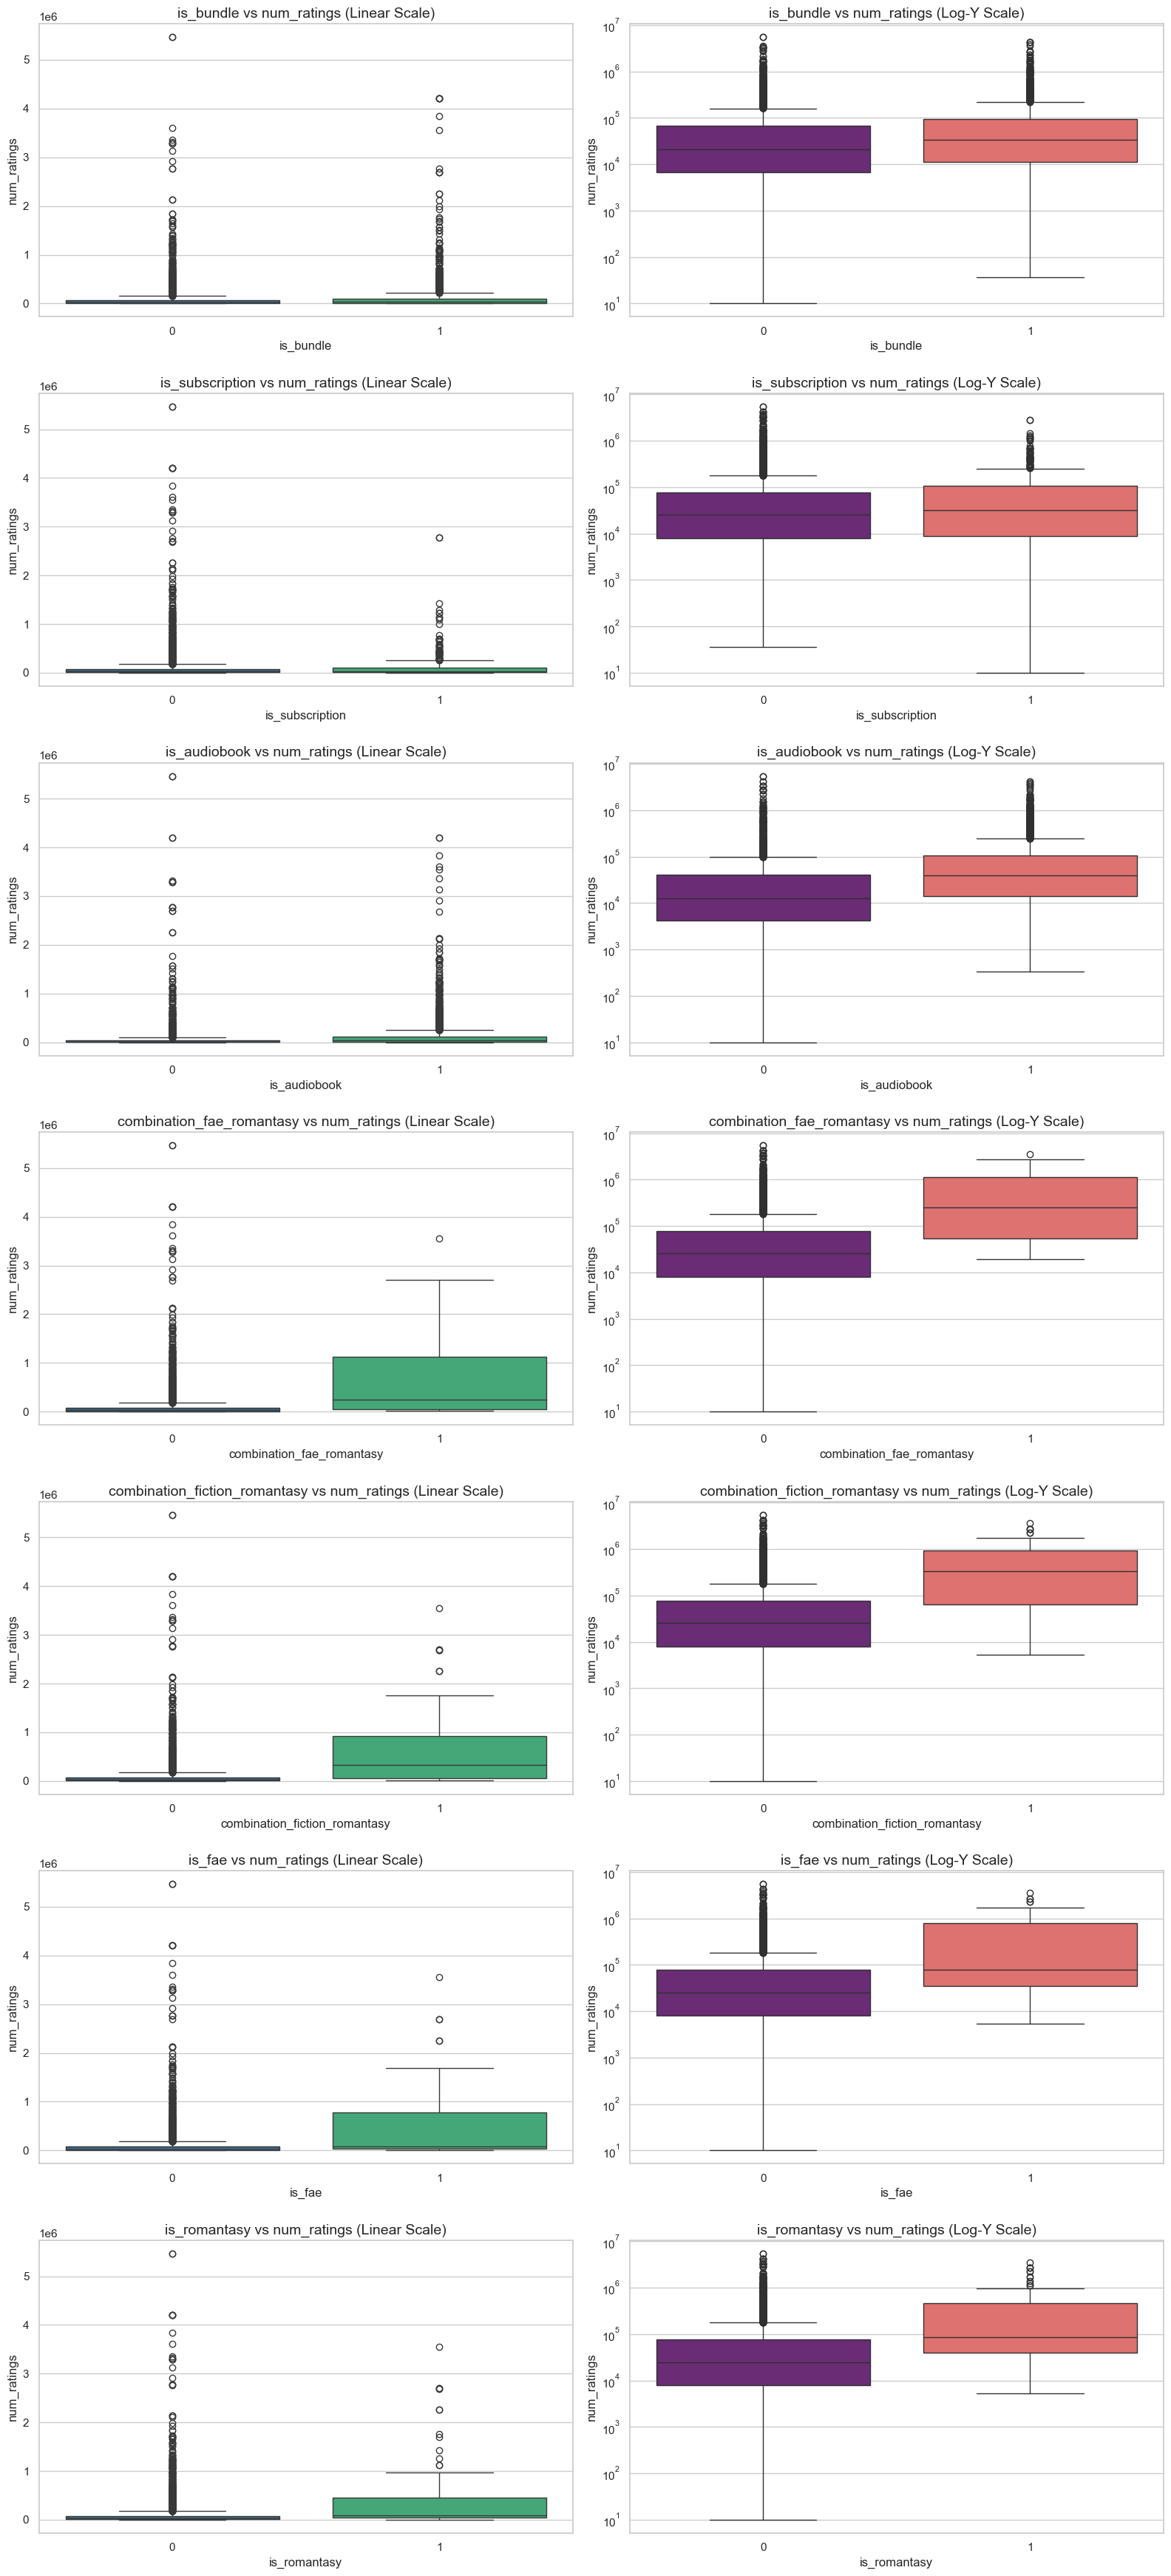

In [24]:
TARGET_COL = "num_ratings"

interest_flags = [
    'is_bundle', 'is_subscription', 'is_audiobook', 
    'combination_fae_romantasy', 'combination_fiction_romantasy', 
    'is_fae', 'is_romantasy'
]

plot_flags = [flag for flag in interest_flags if flag in df_model.columns]

n_rows = len(plot_flags)
fig, axes = plt.subplots(n_rows, 2, figsize=(16, 5 * n_rows))

for idx, col in enumerate(plot_flags):
    sns.boxplot(data=df_model, x=col, y=TARGET_COL, palette='viridis', ax=axes[idx, 0], hue=col, legend=False)
    axes[idx, 0].set_title(f'{col} vs {TARGET_COL} (Linear Scale)', fontsize=14)
    
    sns.boxplot(data=df_model, x=col, y=TARGET_COL, palette='magma', ax=axes[idx, 1], hue=col, legend=False)
    axes[idx, 1].set_yscale('log')
    axes[idx, 1].set_title(f'{col} vs {TARGET_COL} (Log-Y Scale)', fontsize=14)

plt.tight_layout()
plt.show()

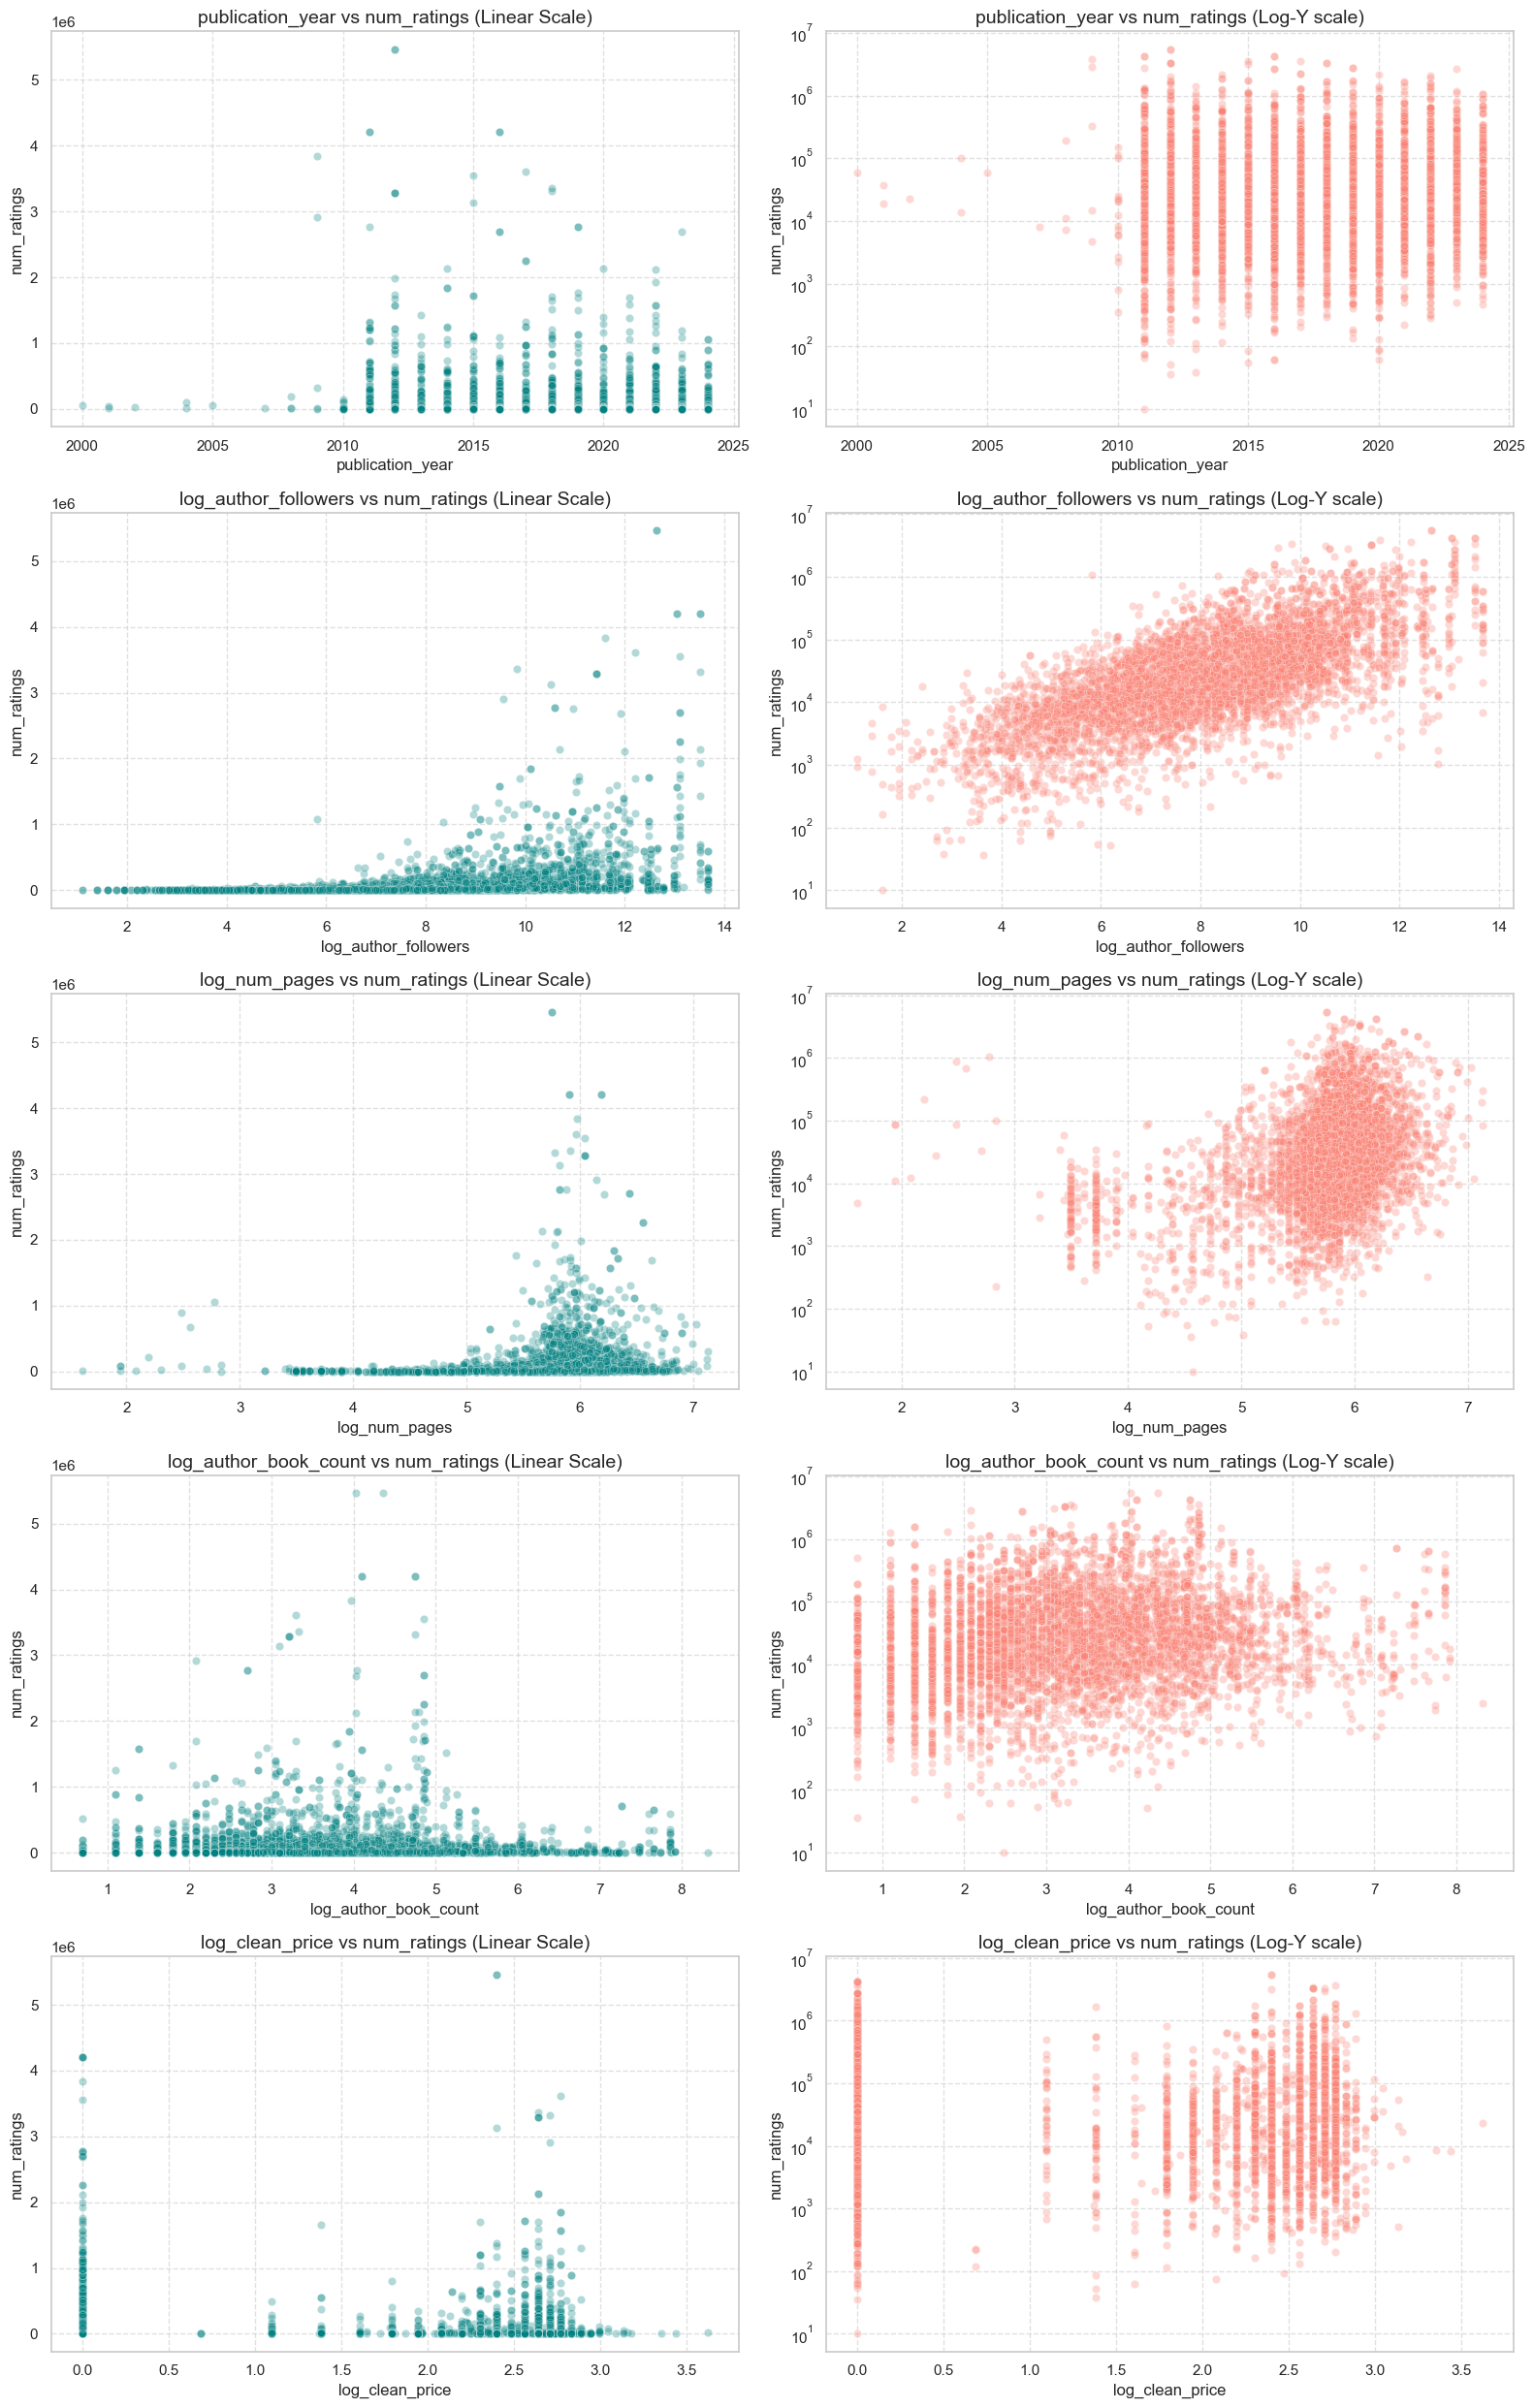

In [25]:
n_rows = len(numerical_continuous)
fig, axes = plt.subplots(n_rows, 2, figsize=(16, 5 * n_rows))

for idx, col in enumerate(numerical_continuous):
    sns.scatterplot(data=df_model, x=col, y=TARGET_COL, alpha=0.3, color='teal', ax=axes[idx, 0])
    axes[idx, 0].set_title(f'{col} vs {TARGET_COL} (Linear Scale)', fontsize=14)
    axes[idx, 0].grid(True, linestyle='--', alpha=0.6)
    
    sns.scatterplot(data=df_model, x=col, y=TARGET_COL, alpha=0.3, color='salmon', ax=axes[idx, 1])
    axes[idx, 1].set_yscale('log')
    
    if col.startswith('log_'):
        axes[idx, 1].set_title(f'{col} vs {TARGET_COL} (Log-Y scale)', fontsize=14)
    elif col == 'publication_year':
        axes[idx, 1].set_title(f'{col} vs {TARGET_COL} (Log-Y scale)', fontsize=14)
    else:
        axes[idx, 1].set_xscale('log')
        axes[idx, 1].set_title(f'{col} vs {TARGET_COL} (Log-Log scale)', fontsize=14)
        
    axes[idx, 1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

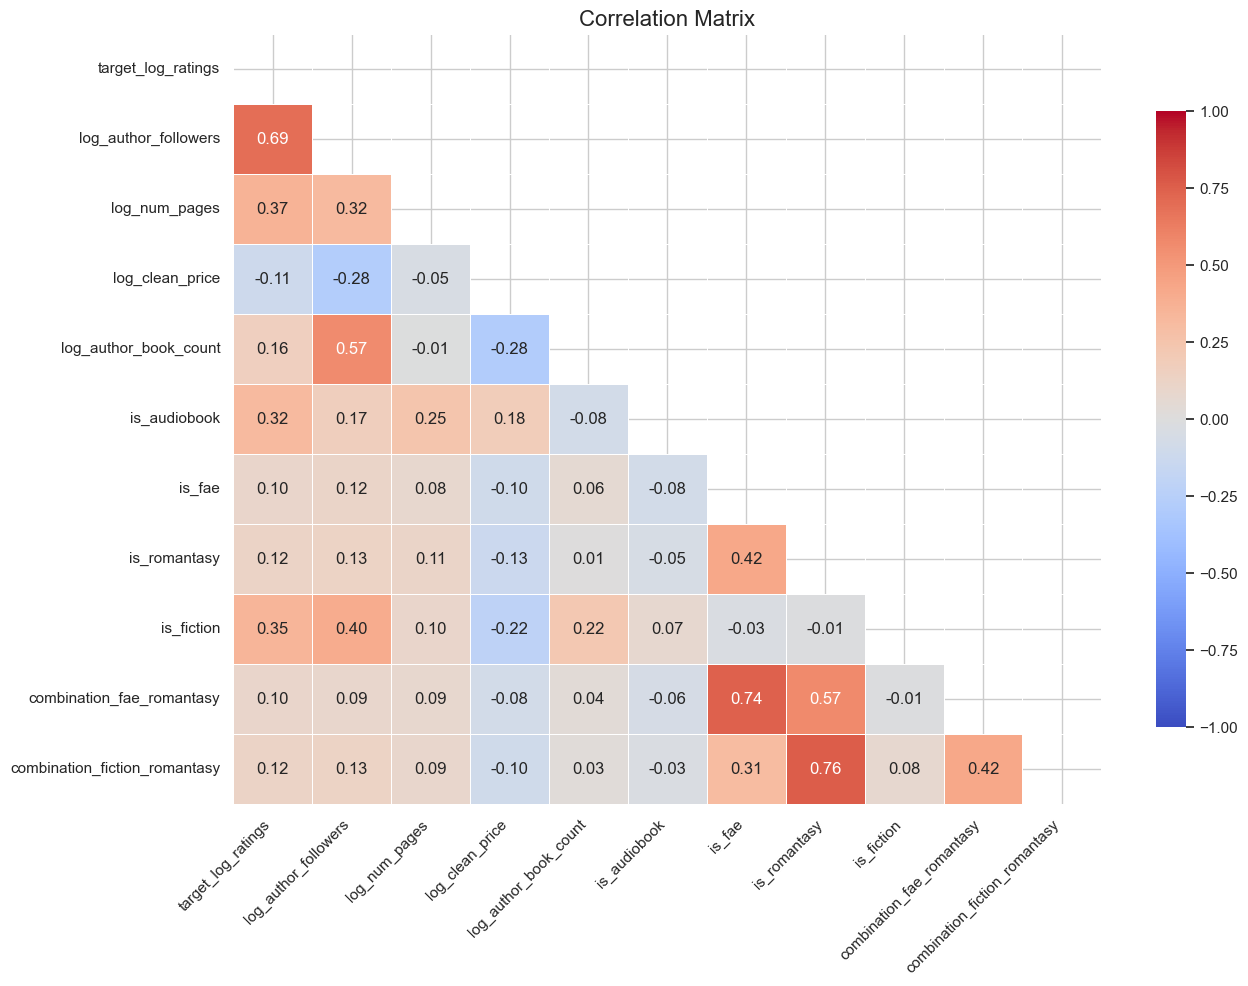

In [29]:
corr_cols = [
    'target_log_ratings',     
    'log_author_followers',                    
    'log_num_pages',           
    'log_clean_price',        
    'log_author_book_count',   
    'is_audiobook',       
    'is_fae',
    'is_romantasy',   
    'is_fiction',    
    'combination_fae_romantasy',   
    'combination_fiction_romantasy'
]

corr_matrix = df_model[corr_cols].corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(14, 10))

sns.heatmap(
    corr_matrix, 
    mask=mask, 
    annot=True, 
    fmt=".2f", 
    cmap='coolwarm', 
    vmin=-1, vmax=1, 
    center=0,
    linewidths=.5,
    cbar_kws={"shrink": .8}
)

plt.title('Correlation Matrix', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.show()

#### Observation:
**1. Log Scale is Better for Big Numbers**
*   In the **Linear scale**, data points concentrated around the lower section of the graph, making it hard to identify the mean, patterns. 
*   In the **Log scale**, data points are distributed much more evenly.

**2. No Redundant Features**
*   There are no pairs with a very high correlation (like 0.9 or 1.0), 
*   **Author followers** has the strongest connection to a book's reach ($0.69$).

#### 1.5 Imputation and Scaling

In [27]:

df_model = df_model.drop(columns=['num_ratings'])

X = df_model.drop(columns=['target_log_ratings'])
y = df_model['target_log_ratings']

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)

print(f"Split Sizes:")
print(f"Train: {X_train.shape[0]} | Val: {X_val.shape[0]} | Test: {X_test.shape[0]}")

cols_to_scale = [col for col in X_train.columns if col.startswith('log_') or col in ['publication_year']]

# fill in missing data points
imputer = SimpleImputer(strategy='median')

# perform z-score normalization
scaler = StandardScaler()

X_train[cols_to_scale] = scaler.fit_transform(imputer.fit_transform(X_train[cols_to_scale]))
X_val[cols_to_scale]   = scaler.transform(imputer.transform(X_val[cols_to_scale]))
X_test[cols_to_scale]  = scaler.transform(imputer.transform(X_test[cols_to_scale]))

X_train = X_train.fillna(0)
X_val = X_val.fillna(0)
X_test = X_test.fillna(0)

Split Sizes:
Train: 3698 | Val: 792 | Test: 793


#### 1.6 Save datasets

In [28]:
save_path = '../../Data/Processed'
os.makedirs(save_path, exist_ok=True)

X_train.to_csv(f'{save_path}/X_train.csv', index=False)
y_train.to_csv(f'{save_path}/y_train.csv', index=False)

X_val.to_csv(f'{save_path}/X_val.csv', index=False)
y_val.to_csv(f'{save_path}/y_val.csv', index=False)

X_test.to_csv(f'{save_path}/X_test.csv', index=False)
y_test.to_csv(f'{save_path}/y_test.csv', index=False)

print(f"\nData saved to {save_path}")


Data saved to ../../Data/Processed
